In [1]:
!nvidia-smi

Mon Apr 23 23:56:30 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 390.48                 Driver Version: 390.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:26:00.0  On |                  N/A |
| 29%   53C    P2    64W / 200W |   1299MiB /  8118MiB |     71%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# importing data science libraries
import pandas as pd

fraud_dataset = pd.read_csv('../data/nonames.csv')
print("There are ", len(fraud_dataset), " samples")
print(fraud_dataset.shape)
print(fraud_dataset.head(10))
print(fraud_dataset.describe())

There are  6362620  samples
(6362620, 12)
   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64      170136.00       160296.36             0.0   
1     1   1864.28       21249.00        19384.72             0.0   
2     1    181.00         181.00            0.00             0.0   
3     1    181.00         181.00            0.00         21182.0   
4     1  11668.14       41554.00        29885.86             0.0   
5     1   7817.71       53860.00        46042.29             0.0   
6     1   7107.77      183195.00       176087.23             0.0   
7     1   7861.64      176087.23       168225.59             0.0   
8     1   4024.36        2671.00            0.00             0.0   
9     1   5337.77       41720.00        36382.23         41898.0   

   newbalanceDest  isFraud  CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER  
0            0.00        0        0         0      0        1         0  
1            0.00        0        0         0      0        1

In [3]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras import backend as K
K.set_session(sess)

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
RANDOM_SEED = 42

In [5]:
X_train, X_test = train_test_split(fraud_dataset, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
# y_train = X_train["isFraud"].copy(deep=True)
X_train.pop("isFraud")
print("X_train: ", X_train.shape)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=RANDOM_SEED)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
y_test = X_test["isFraud"].copy(deep=True)
X_test.pop("isFraud")
print("X_test: ", X_test.shape)

X_train:  (5090096, 12)
X_train:  (5090096, 11)
X_train:  (4072076, 11)
X_val:  (1018020, 11)
X_test:  (1272524, 12)
X_test:  (1272524, 11)


In [6]:
input_shape = X_train.shape[1]

hidden_layer = [10, 8, 4, 3]
input_layer = Input(shape=(input_shape,))
encoder1 = Dense(hidden_layer[0], activation="relu", activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoder2 = Dense(hidden_layer[1], activation="relu", activity_regularizer=regularizers.l1(1e-5))(encoder1)
encoder3 = Dense(hidden_layer[2], activation="relu", activity_regularizer=regularizers.l1(1e-5))(encoder2)
latent = Dense(hidden_layer[3], activation="relu", activity_regularizer=regularizers.l1(10e-5))(encoder3)
decoder1 = Dense(hidden_layer[2], activation="relu", activity_regularizer=regularizers.l1(1e-5))(latent)
decoder2 = Dense(hidden_layer[1], activation="relu", activity_regularizer=regularizers.l1(1e-5))(decoder1)
decoder3 = Dense(input_shape, activation="relu", activity_regularizer=regularizers.l1(1e-5))(decoder2)
autoencoder = Model(inputs=input_layer, outputs=decoder3)

In [7]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 16        
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 40        
__________

In [8]:
nb_epoch = 200
batch_size = 1000
# using mean squared error
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="../saved/basicAE4.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard])

Train on 4072076 samples, validate on 1018020 samples
Epoch 1/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 2193060158957.8557 - acc: 0.5111 - val_loss: 2026429162095.6423 - val_acc: 0.5534
Epoch 2/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1995185270314.0833 - acc: 0.5531 - val_loss: 2025638703794.8342 - val_acc: 0.5580
Epoch 3/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1994795159833.6653 - acc: 0.7028 - val_loss: 2025212696309.2019 - val_acc: 0.7087
Epoch 4/200
4072076/4072076 [==============================] - 30s 7us/step - loss: 1994478511922.1438 - acc: 0.6757 - val_loss: 2025891941051.8875 - val_acc: 0.7044
Epoch 5/200
4072076/4072076 [==============================] - 28s 7us/step - loss: 1994491142011.2002 - acc: 0.6713 - val_loss: 2025094233670.7026 - val_acc: 0.6556
Epoch 6/200
4072076/4072076 [==============================] - 29s 7us/step - loss: 1994417632947.3108 - acc: 0.6615

Epoch 50/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992616502261.6887 - acc: 0.7516 - val_loss: 2023524461541.7871 - val_acc: 0.7630
Epoch 51/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992609758908.7036 - acc: 0.7520 - val_loss: 2023663595436.7139 - val_acc: 0.7530
Epoch 52/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992673057001.6506 - acc: 0.7530 - val_loss: 2023518127586.0752 - val_acc: 0.7547
Epoch 53/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992657740467.2454 - acc: 0.7531 - val_loss: 2023519393457.9292 - val_acc: 0.7659
Epoch 54/200
4072076/4072076 [==============================] - 32s 8us/step - loss: 1992596750844.1521 - acc: 0.7524 - val_loss: 2023685169560.6262 - val_acc: 0.7591
Epoch 55/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992617293770.3164 - acc: 0.7508 - val_loss: 2023518698681.8252 - val_acc: 0.764

4072076/4072076 [==============================] - 31s 8us/step - loss: 1992592476376.6353 - acc: 0.7552 - val_loss: 2023516768624.0293 - val_acc: 0.7621
Epoch 100/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992579365260.4495 - acc: 0.7529 - val_loss: 2023515443053.7861 - val_acc: 0.7635
Epoch 101/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992605025331.7715 - acc: 0.7554 - val_loss: 2023520210144.0486 - val_acc: 0.7344
Epoch 102/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992591710782.5701 - acc: 0.7586 - val_loss: 2023533105011.5801 - val_acc: 0.7550
Epoch 103/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992625597817.3389 - acc: 0.7546 - val_loss: 2024302039449.3508 - val_acc: 0.7727
Epoch 104/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992605797447.5769 - acc: 0.7543 - val_loss: 2023515547026.0879 - val_acc: 0.7710
Epoch 

Epoch 148/200
4072076/4072076 [==============================] - 31s 8us/step - loss: 1992586179386.6804 - acc: 0.7543 - val_loss: 2023515479037.3643 - val_acc: 0.7519
Epoch 149/200
4072076/4072076 [==============================] - 29s 7us/step - loss: 1992582769028.9297 - acc: 0.7599 - val_loss: 2023521769751.7537 - val_acc: 0.7744
Epoch 150/200
4072076/4072076 [==============================] - 28s 7us/step - loss: 1992582228488.5625 - acc: 0.7612 - val_loss: 2023515611203.7559 - val_acc: 0.7611
Epoch 151/200
4072076/4072076 [==============================] - 28s 7us/step - loss: 1992585766310.9392 - acc: 0.7599 - val_loss: 2023515761197.1335 - val_acc: 0.7520
Epoch 152/200
4072076/4072076 [==============================] - 29s 7us/step - loss: 1992587239152.5183 - acc: 0.7608 - val_loss: 2023519725828.3601 - val_acc: 0.7733
Epoch 153/200
4072076/4072076 [==============================] - 28s 7us/step - loss: 1992590367395.2219 - acc: 0.7594 - val_loss: 2023516479313.3799 - val_acc:

Epoch 197/200
4072076/4072076 [==============================] - 27s 7us/step - loss: 1992582327792.9978 - acc: 0.7577 - val_loss: 2023515384917.1570 - val_acc: 0.7607
Epoch 198/200
4072076/4072076 [==============================] - 27s 7us/step - loss: 1992574974252.2073 - acc: 0.7576 - val_loss: 2023545365903.5132 - val_acc: 0.7669
Epoch 199/200
4072076/4072076 [==============================] - 27s 7us/step - loss: 1992572661967.3027 - acc: 0.7585 - val_loss: 2023515504142.6958 - val_acc: 0.7588
Epoch 200/200
4072076/4072076 [==============================] - 27s 7us/step - loss: 1992568230302.5212 - acc: 0.7622 - val_loss: 2023516114760.1262 - val_acc: 0.7753


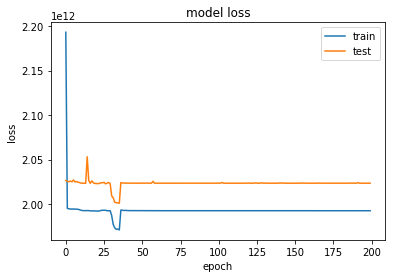

In [9]:
# importing visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

autoencoder = load_model('../saved/basicAE4.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [10]:
import numpy as np


predictions = autoencoder.predict(X_test)
# calculate my own MSE
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})
error_df.describe()
print(predictions.shape)

(1272524, 11)


In [11]:
print(predictions[0][:])
X_test.head(1)

[     0.       7151.7344 186529.     193934.75   291309.72   288420.
      0.          0.          0.          0.          0.    ]


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
3737323,278,330218.42,20866.0,351084.42,452419.57,122201.15,1,0,0,0,0
